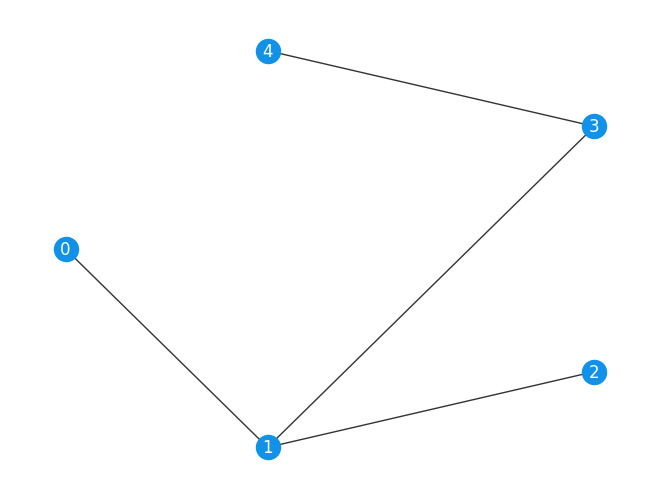

In [91]:
import networkx as nx
import matplotlib.pyplot as plt

# Number of nodes
n = 5
# Create a graph and add nodes and edges
G = nx.Graph()
G.add_nodes_from(range(n))
edges = [(0, 1),(1, 2),(1, 3),(3, 4)]
G.add_edges_from(edges)

# Draw the graph using shell layout
pos = nx.shell_layout(G)

nx.draw(G, pos,with_labels=True,
    node_color="#1192E8",
    edge_color="#333333",
    font_color="white"
)

plt.show()

In [92]:
from qiskit.quantum_info import SparsePauliOp

def min_vertex_cover_hamiltonian(graph, penalty=10):
    """""Constructs the Hamiltonian for the minimum vertex cover problem on a given graph."""
    #Cost function -> F(G) = sum_i x_i - penalty * sum_{(i,j) in E} (1 - x_i)(1 - x_j)
    # Use QUBO formulation:
    # x_i = (1 - Z_i)/2, where Z_i is the Pauli Z operator on qubit i.
    # The minimum eigenvalue of the Hamiltonian will give the minimum vertex cover.

    n = graph.number_of_nodes()
    pauli_terms = {}
    
    # sum_i x_i
    for i in range(n):
        # x_i = (1 - Z_i)/2
        pauli_terms["I"*i + "Z" + "I"*(n-i-1)] = pauli_terms.get("I"*i + "Z" + "I"*(n-i-1), 0) - 0.5
        pauli_terms["I"*n] = pauli_terms.get("I"*n, 0) + 0.5

    # For each edge E(i, j): penalty * sum_{(i,j) in E} (1 - x_i)(1 - x_j)
    for (i, j) in graph.edges():
        # 1
        pauli_terms["I"*n] = pauli_terms.get("I"*n, 0) + penalty * 1
        # -x_i
        pauli_terms["I"*i + "Z" + "I"*(n-i-1)] = pauli_terms.get("I"*i + "Z" + "I"*(n-i-1), 0) + penalty * 0.5
        pauli_terms["I"*n] = pauli_terms.get("I"*n, 0) - penalty * 0.5
        # -x_j
        pauli_terms["I"*j + "Z" + "I"*(n-j-1)] = pauli_terms.get("I"*j + "Z" + "I"*(n-j-1), 0) + penalty * 0.5
        pauli_terms["I"*n] = pauli_terms.get("I"*n, 0) - penalty * 0.5
        # +x_i x_j
        key = ""
        for k in range(n):
            if k == i or k == j:
                key += "Z"
            else:
                key += "I"
        pauli_terms[key] = pauli_terms.get(key, 0) + penalty * 0.25
        pauli_terms["I"*i + "Z" + "I"*(n-i-1)] = pauli_terms.get("I"*i + "Z" + "I"*(n-i-1), 0) - penalty * 0.25
        pauli_terms["I"*j + "Z" + "I"*(n-j-1)] = pauli_terms.get("I"*j + "Z" + "I"*(n-j-1), 0) - penalty * 0.25
        pauli_terms["I"*n] = pauli_terms.get("I"*n, 0) + penalty * 0.25

    # Conversion to list for SparsePauliOp
    pauli_list = [(k, v) for k, v in pauli_terms.items() if abs(v) > 1e-8]
    return SparsePauliOp.from_list(pauli_list)

In [93]:
from qiskit.circuit.library import QAOAAnsatz


hamiltonian = min_vertex_cover_hamiltonian(G, penalty=10)
print(hamiltonian)

# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=10)

#ansatz.decompose(reps=3).draw("mpl")

SparsePauliOp(['ZIIII', 'IIIII', 'IZIII', 'IIZII', 'IIIZI', 'IIIIZ', 'ZZIII', 'IZZII', 'IZIZI', 'IIIZZ'],
              coeffs=[ 2. +0.j, 12.5+0.j,  7. +0.j,  2. +0.j,  4.5+0.j,  2. +0.j,  2.5+0.j,
  2.5+0.j,  2.5+0.j,  2.5+0.j])


In [94]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
# Using local backend for simulation
estimator = Estimator()
sampler = Sampler()

In [95]:
import numpy as np
# Generate random initial parameters for the ansatz
x0 = np.random.uniform(0,2*np.pi, ansatz.num_parameters)
print(x0)

[2.73394441 1.73473027 4.57993417 4.8330293  1.18167142 1.75452478
 5.86595074 4.24786094 3.08851653 0.08095336 2.96736627 5.87420084
 1.9459385  1.85286835 3.89388182 3.90110939 3.89704422 1.06945535
 6.03109345 1.97454809]


In [96]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator"""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

In [ ]:
from scipy.optimize import minimize

# Uncomment the following line to use COBYLA method
#result = minimize(cost_func_vqe, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

#Using gradient approximation with L-BFGS-B
result = minimize(cost_func_vqe, x0, 
    args=(ansatz, hamiltonian, estimator), 
    method="L-BFGS-B",
    jac="2-point",  
    options={'maxiter': 1000, 'gtol': 1e-2}
)

In [98]:
result

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 2.00041556876559
        x: [ 3.654e+00  1.564e+00 ...  5.866e+00  1.816e+00]
      nit: 453
      jac: [ 3.505e-03 -1.281e-03 ...  1.098e-04  7.947e-04]
     nfev: 10626
     njev: 506
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>

In [99]:
from numpy.linalg import eigvalsh

# Error calculation
solution_eigenvalue = min(eigvalsh(hamiltonian.to_matrix()))
print(solution_eigenvalue)

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue)*100}"
)

2.0
Percent error: 0.020778438279500655
